# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [1]:
student1 = "Yu-Ting Huang"
student2 = "Zhantao Deng"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [1]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization
from keras.regularizers import l1, l2
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


### Plotting

In [2]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

In [3]:
from keras.datasets import mnist, fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

Display some samples from MINST 


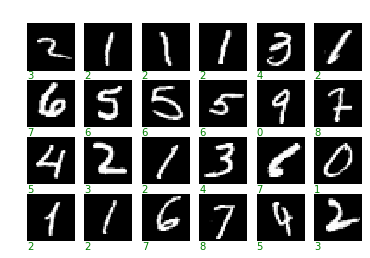

In [4]:
print("Display some samples from MINST ")
fig = plot_some_samples(x=x_train, y=y_train)

Display some samples from Fashion-MINST 


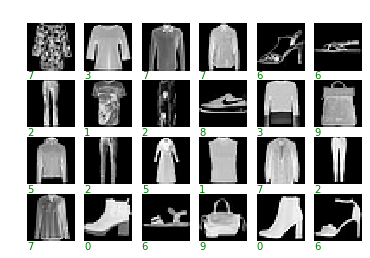

In [5]:
print("Display some samples from Fashion-MINST ")
fig = plot_some_samples(x=x_fashion_train, y=y_fashion_train)

**Answer to question 2**:

The green digits are mapped from given labels by +1.

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

1.One-hot-coding labels

In [6]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

2.flatten the input images

In [7]:
x_train_CNN = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)/np.max(x_train)
x_test_CNN = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)/np.max(x_test)

x_fashion_train_CNN = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1], x_fashion_train.shape[2], 1)/np.max(x_fashion_train)
x_fashion_test_CNN = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1], x_fashion_test.shape[2], 1)/np.max(x_fashion_test)

In [8]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

1.Define the model

In [9]:
input_shape = (784, )
nb_classes = 10

model = Sequential()
model.add(Dense(nb_classes, input_shape = input_shape))
model.add(Activation('softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer = sgd,
              metrics=['accuracy'])

2.Set training parameters and fit the data

In [10]:
batch_size = 128
epochs = 60
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)

3.Display the training history

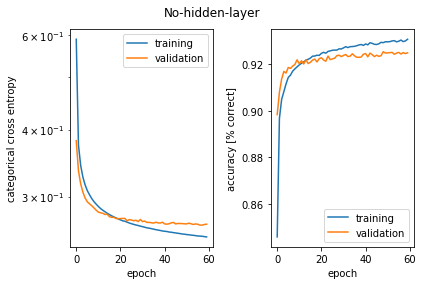

In [11]:
fig = plot_history(history, 'No-hidden-layer')

4.Display the misclassified samples

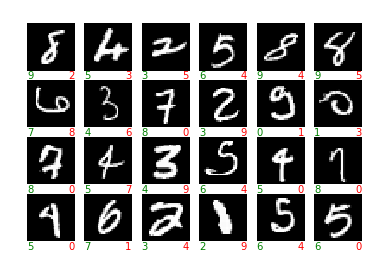

In [12]:
# predict labels
yhat_test = model.predict_classes(x_test)
# misclassified testing samples
misclassified_inds = np.argwhere( yhat_test != np.argmax(y_test,axis=1)).flatten()
# display some misclassified samples
fig = plot_some_samples(x_test, y_test, yhat_test, misclassified_inds)

**Answer to question 8**:

The green digits are true labels plus 1 while the red digits are the corresponding predictions. 

5.Repeat all the steps for the fashion-minst data set

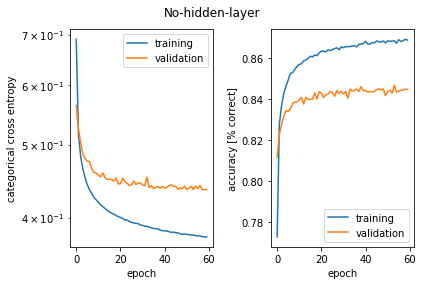

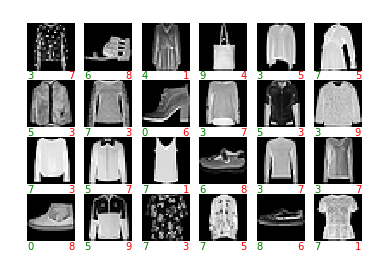

In [26]:
# 1.Define the model
input_shape = (784, )
nb_classes = 10

model = Sequential()
model.add(Dense(nb_classes, input_shape = input_shape))
model.add(Activation('softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer = sgd,
              metrics=['accuracy'])

# 2.Set training parameters and fit the data
batch_size = 128
epochs = 60
history = model.fit(x_fashion_train, y_fashion_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_fashion_test, y_fashion_test))
score = model.evaluate(x_fashion_test, y_fashion_test, verbose=0)

# 3.Display the training history
fig = plot_history(history, 'No-hidden-layer')

# 4.Display the misclassified samples
# predict labels
yhat_test = model.predict_classes(x_fashion_test)
# misclassified testing samples
misclassified_inds = np.argwhere( yhat_test != np.argmax(y_fashion_test,axis=1)).flatten()
# display some misclassified samples
fig = plot_some_samples(x_fashion_test, y_fashion_test, yhat_test, misclassified_inds)

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

**1. Use one hidden layer with 128 units and the 'relu' activation; Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD).**

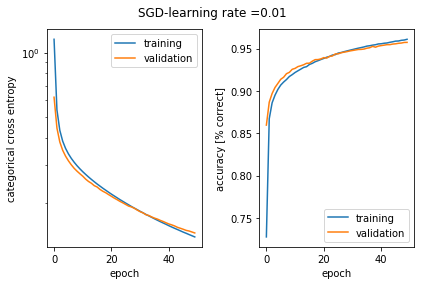

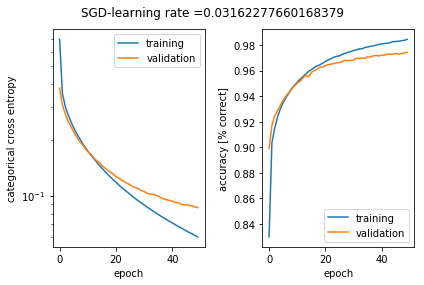

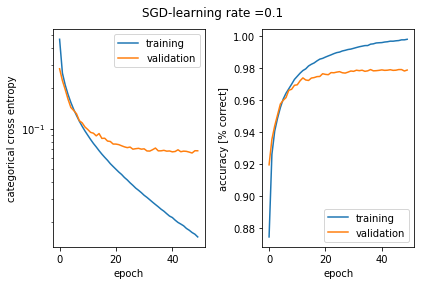

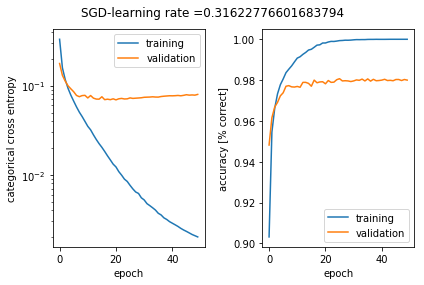

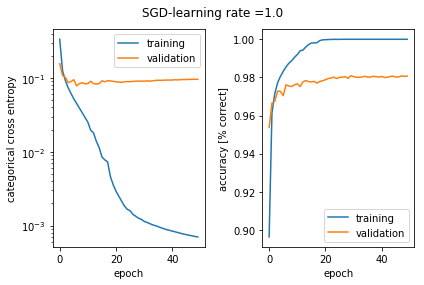

In [13]:
for learning_rate in np.logspace(-2, 0, 5):
    
    model_Ex3 = Sequential()
    model_Ex3.add(Dense(units=128, activation='relu',input_shape=input_shape))
    model_Ex3.add(Dense(units=nb_classes, activation='softmax'))

    model_Ex3.compile(loss='categorical_crossentropy',
                      optimizer=SGD(lr = learning_rate),
                      metrics=['accuracy'])

    history = model_Ex3.fit(x_train, y_train,
                           batch_size = 128,
                           epochs = 50, 
                           verbose = 0,
                           validation_data=(x_test, y_test))

    fig = plot_history(history, 'SGD-learning rate ='+ str(learning_rate))

Viewing from the figures above, we can find that:
>1. The smaller of the learning rate, the slower of convergence. 
>2. A large learning rate counld lead to overfitting -- validation errors could slightly increase after around 5-8 epoch.

**2. Replace the stochastic gradient descent optimizer with the Adam optimizer**

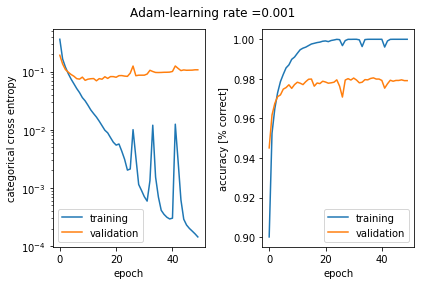

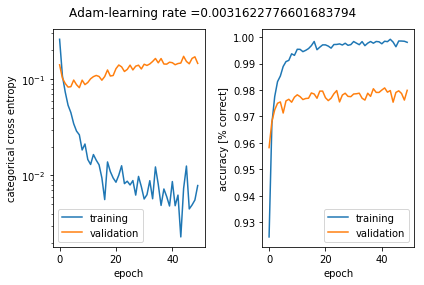

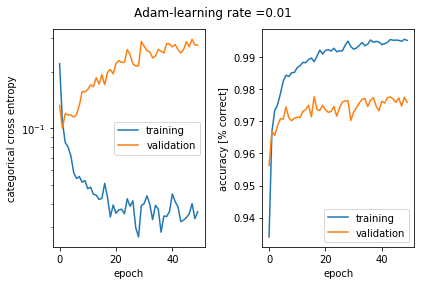

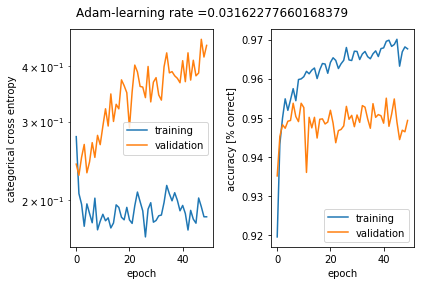

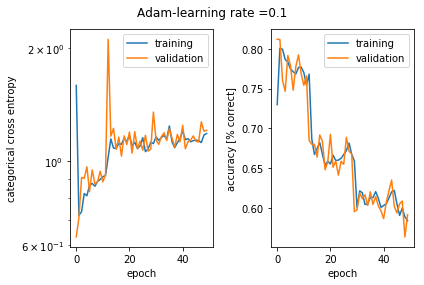

In [14]:
for learning_rate in np.logspace(-3, -1, 5):
    
    model_Ex3 = Sequential()
    model_Ex3.add(Dense(units=128, activation='relu',input_shape=input_shape))
    model_Ex3.add(Dense(units=nb_classes, activation='softmax'))

    model_Ex3.compile(loss='categorical_crossentropy',
                      optimizer=Adam(lr = learning_rate),
                      metrics=['baccuracy'])

    history = model_Ex3.fit(x_train, y_train,
                           batch_size = 128,
                           epochs = 50, 
                           verbose = 0,
                           validation_data=(x_test, y_test))

    fig = plot_history(history, 'Adam-learning rate ='+ str(learning_rate))

Viewing from the figures above, we can find that:
>1. Adam prefers smaller learning rates than sgd.
>2. A large learning rate counld lead to a strong overfitting after around 5 epoch.

**3. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.**

In [20]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

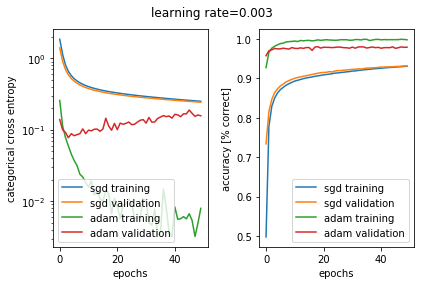

In [16]:
learning_rate = 0.003 

# model for adam
model_Ex3_4_adam = Sequential()
model_Ex3_4_adam.add(Dense(units=128, activation='relu',input_shape=input_shape))
model_Ex3_4_adam.add(Dense(units=nb_classes, activation='softmax'))
model_Ex3_4_adam.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr = learning_rate),
                  metrics=['accuracy'])
adam = model_Ex3_4_adam.fit(x_train, y_train,
                       batch_size = 128,
                       epochs = 50, 
                       verbose = 0,
                       validation_data=(x_test, y_test))

# model for sgd
model_Ex3_4_sgd = Sequential()
model_Ex3_4_sgd.add(Dense(units=128, activation='relu',input_shape=input_shape))
model_Ex3_4_sgd.add(Dense(units=nb_classes, activation='softmax'))

model_Ex3_4_sgd.compile(loss='categorical_crossentropy',
                  optimizer=SGD(lr = learning_rate),
                  metrics=['accuracy'])
sgd = model_Ex3_4_sgd.fit(x_train, y_train,
                       batch_size = 128,
                       epochs = 50, 
                       verbose = 0,
                       validation_data=(x_test, y_test))

fig = comparison_plot(sgd, adam, 'sgd', 'adam', 'learning rate='+str(learning_rate))

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A)When lr = 0.3, sdg converges quickly but then it overfits the training data

B)When lr = 0.01, sdg converges slowly.

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: It shows that at around 5-8 epochs the Adam starts to overfit.

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**:When a model begin to overfit training data, the loss curve of testing data will begin to raise and the accuracy cureve of testing data will begin to viberate and decrease.

**4. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above.**

Since we use a small learning rate (0.003), in order to train the network throughly, the 'epoch' is set to be 150.

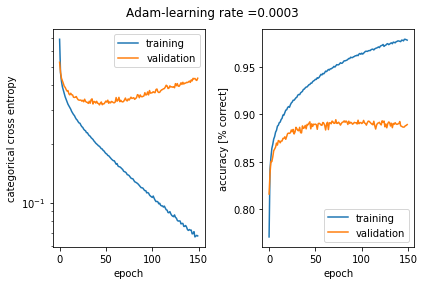

In [14]:
learning_rate = 3e-4

model_Ex3_5 = Sequential()
model_Ex3_5.add(Dense(units=128, activation='relu',input_shape=input_shape))
model_Ex3_5.add(Dense(units=nb_classes, activation='softmax'))
model_Ex3_5.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr = learning_rate),
                  metricsbaccuracy'])
adam = model_Ex3_5.fit(x_fashion_train, y_fashion_train,
                       batch_size = 128,
                       epochs = 150, 
                       verbose = 0,
                       validation_data=(x_fashion_test, y_fashion_test))

fig = plot_history(adam, 'Adam-learning rate ='+ str(learning_rate))

In Fashion-MNIST dataset, the network does not perform as well as in MNIST. This could be because Fashion-MNIST is more difficult than MNIST. 

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

In [17]:
def hidden_layer(hidden_neurons, hidden_layer_size, 
                 learning_rate, optimizer, 
                 bn, dropout, reg, epochs, verbose,
                 x_train, y_train, x_test, y_test, reg_value = 1e-6):
    input_shape = (784, )
    nb_classes = 10
    batch_size = 128

    model = Sequential()
    
    # First hidden layer
    model.add(Dense(hidden_neurons, input_shape = input_shape))
    
    if(bn == True):
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    if(dropout == True):
        model.add(Dropout(0.25))

    # Second and third hidden layer
    if(hidden_layer_size > 1):
        for i in range(hidden_layer_size - 1):
            model.add(Dense(50))
            if(bn == True):
                model.add(BatchNormalization())   
            model.add(Activation('relu'))
            if(dropout == True):
                model.add(Dropout(0.25))
 
    # Output layer
    if reg == 'l1':
        model.add(Dense(nb_classes, kernel_regularizer = l1(reg_value)))
    elif reg == 'l2':
        model.add(Dense(nb_classes, kernel_regularizer = l2(reg_value)))
    else:
        model.add(Dense(nb_classes))        
    model.add(Activation('softmax' ))

    if(optimizer == 'sgd'):
        optimizer = SGD(lr = learning_rate)
    else:
        optimizer = Adam(lr = learning_rate) 
        
    model.compile(loss ='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = verbose,
                    validation_data = (x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose = 0)
    model.summary()
    return history

**1.Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)**

No regularization is considered
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 10)                7850      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 10)                110       
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________
No regularization is considered
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 32)                25120     
__________

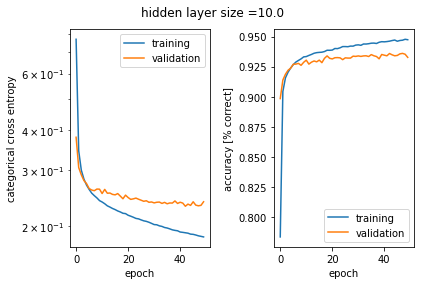

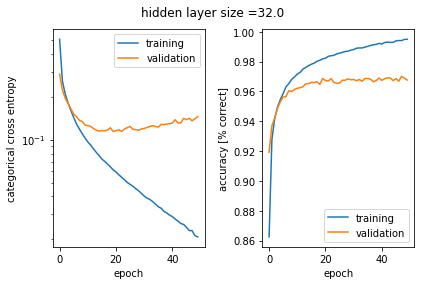

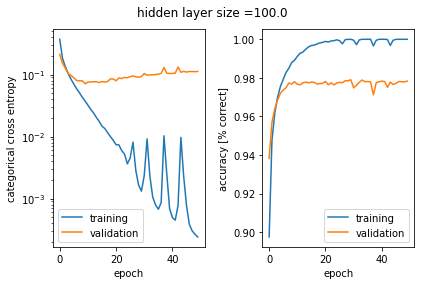

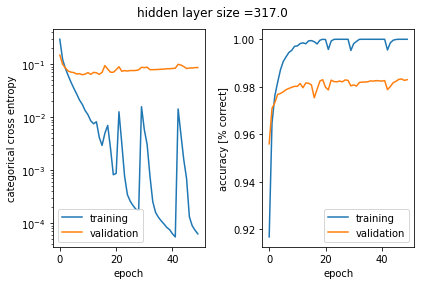

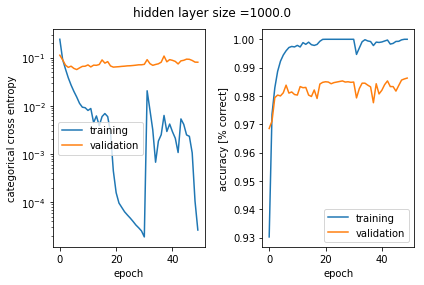

In [18]:
history_size = []
for number_of_neuron in np.ceil(np.logspace(1, 3, 5)):
    history = hidden_layer(hidden_neurons = int(number_of_neuron), hidden_layer_size = 1,
                           learning_rate = 0.001, optimizer = 'adam', 
                           bn = False, dropout = False, reg = False, epochs = 50, verbose = 0,
                           x_train = x_train, x_test = x_test, y_train = y_train, y_test = y_test)
    history_size.append(history)
    fig = plot_history(history, 'hidden layer size ='+ str(number_of_neuron))

**2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the general approximation theorem? If not, what might be practical reasons for the deviation? (2 sentences max.)**

In [29]:
lowest_loss = [min(x.history['val_loss']) for x in history_size]
highest_acc = [min(x.history['acc']) for x in history_size]

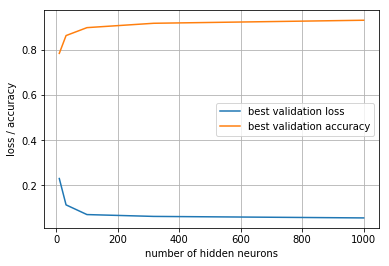

In [30]:
plt.plot(np.ceil(np.logspace(1, 3, 5)),lowest_loss, np.ceil(np.logspace(1, 3, 5)), highest_acc )
plt.grid()
plt.xlabel('number of hidden neurons')
plt.ylabel('loss / accuracy')
plt.legend(['best validation loss', 'best validation accuracy']);

**Answer to question 2:**

Yes, this experiment shows that the more hidden neurons the network contains the better performance it has which is consistent with the general approximation theorem that "a feed-forward network with a single hidden layer containing a finite number of neurons can approximate continuous functions on compact subsets of R^n, under mild assumptions on the activation function".

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

**Question 1**

1. No batch normalization, no dropout layers and regularizations

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 50)                39250     
_________________________________________________________________
activation_16 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2550      
_________________________________________________________________
activation_17 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 50)                2550      
_________________________________________________________________
activation_18 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                510       
__________

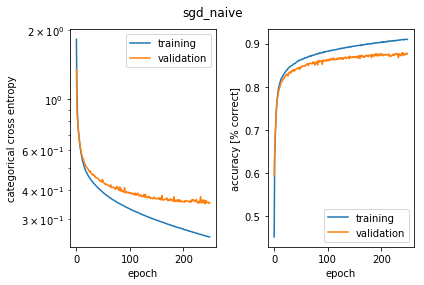

In [22]:
sgd_navie = hidden_layer(hidden_neurons = 50, hidden_layer_size = 3,
                   learning_rate = 0.003, optimizer = 'sgd', 
                   bn = False, dropout = False, reg = False, epochs = 250, verbose = 0,
                   x_train = x_fashion_train, x_test = x_fashion_test, y_train = y_fashion_train, y_test = y_fashion_test)
fig = plot_history(sgd_navie, 'sgd_naive')

2. Only batch match

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 50)                39250     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
activation_6 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                2550      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50)                200       
_________________________________________________________________
activation_7 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                2550      
__________

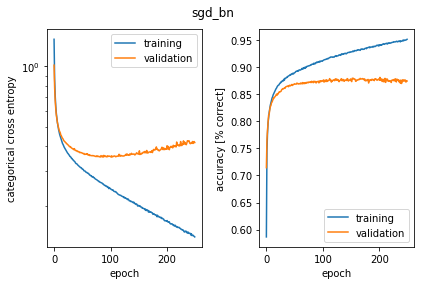

In [17]:
sgd_bn = hidden_layer(hidden_neurons = 50, hidden_layer_size = 3,
                   learning_rate = 0.003, optimizer = 'sgd', 
                   bn = True, dropout = False, reg = False, epochs = 250, verbose = 0,
                   x_train = x_fashion_train, x_test = x_fashion_test, y_train = y_fashion_train, y_test = y_fashion_test)
fig = plot_history(sgd_bn, 'sgd_bn')

> After adding batch normalization layer, the network converges faster and quickly overfits the training data as batch normalization guarantees that all inputs will explore both the linear and nonlinear part of the activation function.

3. Only dropout layers

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 50)                39250     
_________________________________________________________________
activation_10 (Activation)   (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                2550      
_________________________________________________________________
activation_11 (Activation)   (None, 50)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 50)                2550      
__________

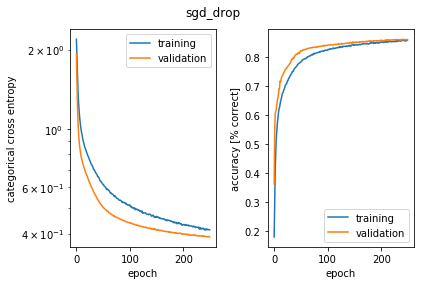

In [18]:
sgd_drop = hidden_layer(hidden_neurons = 50, hidden_layer_size = 3,
                   learning_rate = 0.003, optimizer = 'sgd', 
                   bn = False, dropout = True, reg = False, epochs = 250, verbose = 0,
                   x_train = x_fashion_train, x_test = x_fashion_test, y_train = y_fashion_train, y_test = y_fashion_test)
fig = plot_history(sgd_drop, 'sgd_drop')

> As training a dropout network is equal to training several models at the same time (like bagging), after appending dropout layers, the network converges slower. But since the dropout method enforces representation sharing, it makes the network more robust so the learning curves become more smooth. 

4. Only l1 regularization terms

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 50)                39250     
_________________________________________________________________
activation_9 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                2550      
_________________________________________________________________
activation_10 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 50)                2550      
_________________________________________________________________
activation_11 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)                510       
__________

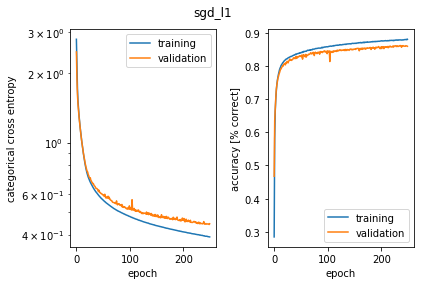

In [22]:
sgd_l1 = hidden_layer(hidden_neurons = 50, hidden_layer_size = 3,
                     learning_rate = 0.003, optimizer = 'sgd', 
                     bn = False, dropout = False, reg = 'l1', 
                     epochs = 250, verbose = 0,
                     x_train = x_fashion_train, x_test = x_fashion_test, 
                     y_train = y_fashion_train, y_test = y_fashion_test,
                     reg_value = 0.01)
fig = plot_history(sgd_l1, 'sgd_l1')

5. Only l2 regularizaiton terms

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 50)                39250     
_________________________________________________________________
activation_14 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 50)                2550      
_________________________________________________________________
activation_15 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 50)                2550      
_________________________________________________________________
activation_16 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 10)                510       
__________

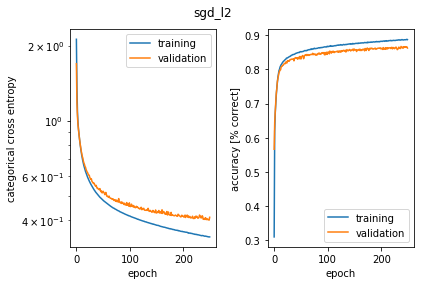

In [19]:
sgd_l2 = hidden_layer(hidden_neurons = 50, hidden_layer_size = 3,
                      learning_rate = 0.003, optimizer = 'sgd', 
                      bn = False, dropout = False, reg = 'l2', 
                      epochs = 250, verbose = 0,
                      x_train = x_fashion_train, x_test = x_fashion_test, 
                      y_train = y_fashion_train, y_test = y_fashion_test,
                      reg_value = 0.01)
fig = plot_history(sgd_l2, 'sgd_l2')

6. Batch normalization + dropout layers + regularizations

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 50)                39250     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
activation_12 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50)                200       
_________________________________________________________________
activation_13 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                2550      
__________

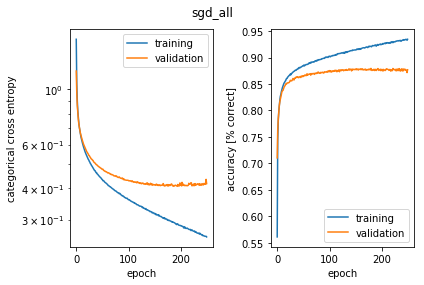

In [18]:
sgd_tuned = hidden_layer(hidden_neurons = 50, hidden_layer_size = 3,
                       learning_rate = 0.003, optimizer = 'sgd', 
                       bn = True, dropout = False, reg = 'l2',
                       epochs = 250, verbose = 0,
                       x_train = x_fashion_train, x_test = x_fashion_test, 
                       y_train = y_fashion_train, y_test = y_fashion_test,
                       reg_value = 0.01)
fig = plot_history(sgd_tuned, 'sgd_all')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 50)                39250     
_________________________________________________________________
batch_normalization_4 (Batch (None, 50)                200       
_________________________________________________________________
activation_20 (Activation)   (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 50)                2550      
_________________________________________________________________
batch_normalization_5 (Batch (None, 50)                200       
_________________________________________________________________
activation_21 (Activation)   (None, 50)                0         
__________

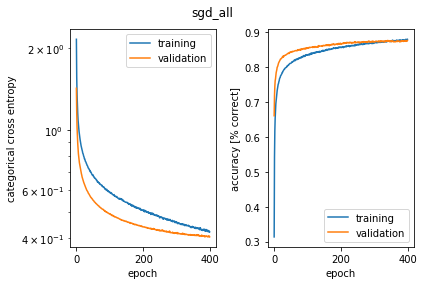

In [24]:
sgd_tuned = hidden_layer(hidden_neurons = 50, hidden_layer_size = 3,
                       learning_rate = 0.003, optimizer = 'sgd', 
                       bn = True, dropout = True, reg = 'l2',
                       epochs = 400, verbose = 0,
                       x_train = x_fashion_train, x_test = x_fashion_test, 
                       y_train = y_fashion_train, y_test = y_fashion_test,
                       reg_value = 0.01)
fig = plot_history(sgd_tuned, 'sgd_all')

**Question 2**

After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)

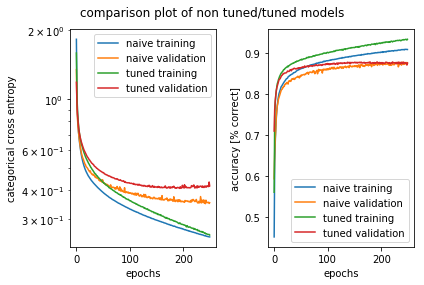

In [23]:
fig = comparison_plot(sgd_navie, sgd_tuned, 'naive', 'tuned', 'comparison plot of non tuned/tuned models')

**Answer to question 2 (comments):**

Viewing from the two figures above, we can find that the tunned model converges at around 50 epoches while the naive model converges at around 200 epoches. In addition, the naive model can not perform as good as the tunned one until 210 epoches. 

**Question 3**

Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 50)                39250     
_________________________________________________________________
batch_normalization_10 (Batc (None, 50)                200       
_________________________________________________________________
activation_26 (Activation)   (None, 50)                0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 50)                2550      
_________________________________________________________________
batch_normalization_11 (Batc (None, 50)                200       
_________________________________________________________________
activation_27 (Activation)   (None, 50)                0         
__________

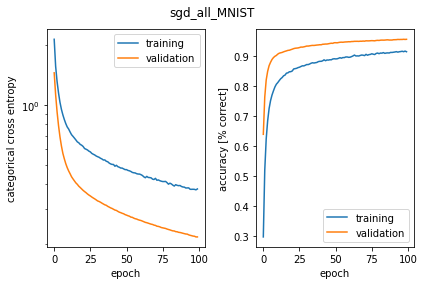

In [23]:
sgd_tuned_MNIST = hidden_layer(hidden_neurons = 50, hidden_layer_size = 3,
                       learning_rate = 0.003, optimizer = 'sgd', 
                       bn = True, dropout = True, reg = 'l2',
                       epochs = 100, verbose = 0,
                       x_train = x_train, x_test = x_test, 
                       y_train = y_train, y_test = y_test,
                       reg_value = 0.005)
fig = plot_history(sgd_tuned_MNIST, 'sgd_all_MNIST')

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

**Question 1**

Here we accomplish a function which can generate a CNN according to the given parameters and architectures.

In [9]:
def CNN(bn, activation, hidden_layer, filter_size, learning_rate, epochs, verbose, x_train, x_test, y_train, y_test):
    pool_size = (2,2)
    reg = 0.01
    input_shape = (28, 28, 1)
    nb_classes = 10
    batch_size = 128
 
    model = Sequential()

    model.add(Conv2D(32, 3, padding='same', input_shape = input_shape))
    if(bn == True):
        model.add(BatchNormalization())
    if(activation == 'relu'):
        model.add(Activation('relu'))
    else:
        model.add(Activation('sigmoid'))
    model.add(MaxPooling2D(pool_size=pool_size, padding = 'same'))
    
    if(hidden_layer == True):
        model.add(Conv2D(filter_size, 5, padding='same'))
        if(bn == True):
            model.add(BatchNormalization())
        if(activation == 'relu'):
            model.add(Activation('relu'))
        else:
            model.add(Activation('sigmoid'))
        model.add(MaxPooling2D(pool_size=pool_size, padding = 'same'))
    
    model.add(Flatten())
    model.add(Dense(128, kernel_regularizer=l2(reg))) # Fully connected layer (128 neurons)
    if(bn == True):
        model.add(BatchNormalization())
    if(activation == 'relu'):
        model.add(Activation('relu'))
    else:
        model.add(Activation('sigmoid'))
    
    model.add(Dense(nb_classes, kernel_regularizer=l2(reg)))
    if(bn == True):
        model.add(BatchNormalization())
    model.add(Activation('softmax')) 
    optimizer = Adam(lr = learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    history = model.fit(x_train, y_train,
                batch_size = batch_size,
                epochs = epochs,
                verbose = verbose,
                validation_data = (x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose = verbose)
    return history

**Question 2**

In the following, we will run MNIST and Fashion MNIST under different architectures (filter sizes), and plot their learning rate to compare the performance.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               802944    
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
__________

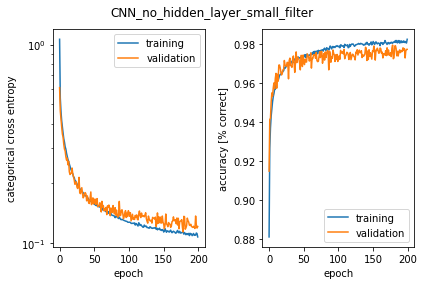

In [10]:
CNN_no_hidden_layer_small_filter = CNN(bn = False, activation = 'relu', hidden_layer = False, filter_size = 32, learning_rate = 3e-4, epochs = 200, verbose = 0,
                          x_train = x_train_CNN, x_test = x_test_CNN, 
                          y_train = y_train, y_test = y_test)
fig = plot_history(CNN_no_hidden_layer_small_filter, 'CNN_no_hidden_layer_small_filter')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
activation_24 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               802944    
_________________________________________________________________
activation_25 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1290      
__________

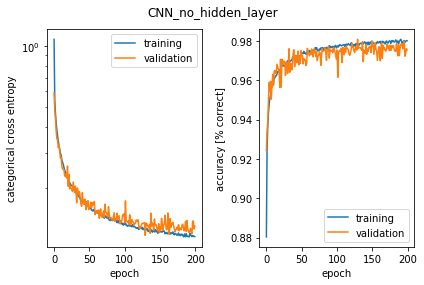

In [21]:
CNN_no_hidden_layer = CNN(bn = False, activation = 'relu', hidden_layer = False, filter_size = 64, learning_rate = 3e-4, epochs = 200, verbose = 0,
                          x_train = x_train_CNN, x_test = x_test_CNN, 
                          y_train = y_train, y_test = y_test)
fig = plot_history(CNN_no_hidden_layer, 'CNN_no_hidden_layer')

>We can see that bigger filter size will increase the accuracy. Hence, in the following we will use filter_size 64.

Below we run MNIST and Fashion MNIST with/out hidden layer and under different parameters including learning rate and epoches.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
activation_27 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 64)        51264     
_________________________________________________________________
activation_28 (Activation)   (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 3136)              0         
__________

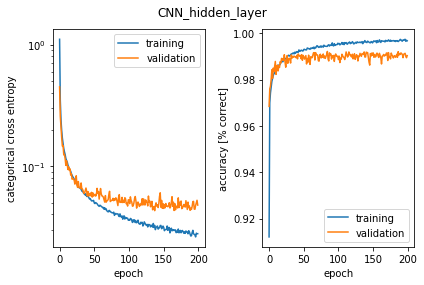

In [22]:
CNN_hidden_layer = CNN(bn = False, activation = 'relu', hidden_layer = True, filter_size = 64, learning_rate = 3e-4, epochs = 200, verbose = 0,
                       x_train = x_train_CNN, x_test = x_test_CNN, 
                       y_train = y_train, y_test = y_test)
fig = plot_history(CNN_hidden_layer, 'CNN_hidden_layer')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_9 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               802944    
_________________________________________________________________
activation_10 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
__________

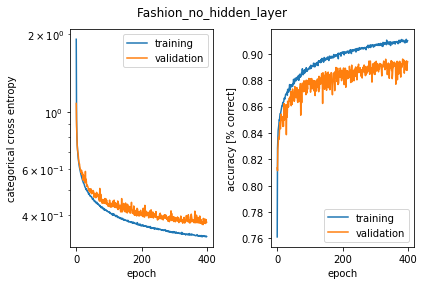

In [15]:
Fashion_no_hidden_layer = CNN(bn = False, activation = 'relu', hidden_layer = False, filter_size = 64, learning_rate = 1e-4, epochs = 400, verbose = 0,
                          x_train = x_fashion_train_CNN, x_test = x_fashion_test_CNN, 
                          y_train = y_fashion_train, y_test = y_fashion_test)
fig = plot_history(Fashion_no_hidden_layer, 'Fashion_no_hidden_layer')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
activation_34 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 64)        51264     
_________________________________________________________________
activation_35 (Activation)   (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 3136)              0         
__________

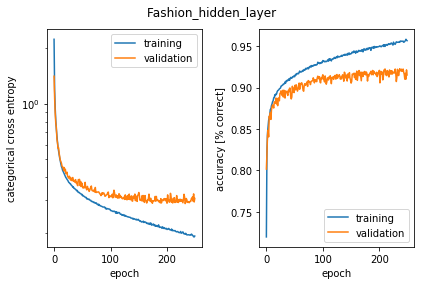

In [24]:
Fashion_hidden_layer = CNN(bn = False, activation = 'relu', hidden_layer = True, filter_size = 64, learning_rate = 1e-4, epochs = 250, verbose = 0,
                          x_train = x_fashion_train_CNN, x_test = x_fashion_test_CNN, 
                          y_train = y_fashion_train, y_test = y_fashion_test)
fig = plot_history(Fashion_hidden_layer, 'Fashion_hidden_layer')

We can see that the accuracies are increased after we add one more CNN hidden layer under both MNIST and Fashion MNIST datasets.

**Answer to question 3:**

In the previous exercise, we get that MNIST and Fashion MNIST can achieve accuracy around 0.9 and 0.8 on validation set using fully-connected architecture. In this exercise, we get that MNIST and Fashion MNIST can achieve accuracy around 0.98 and 0.9 on validation set using CNN architecture. It is obvious that CNN architecture improves the performance on both datasets. 

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

**Training without batch normalization**
1. On MNIST

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
activation_41 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 64)        51264     
_________________________________________________________________
activation_42 (Activation)   (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 3136)              0         
__________

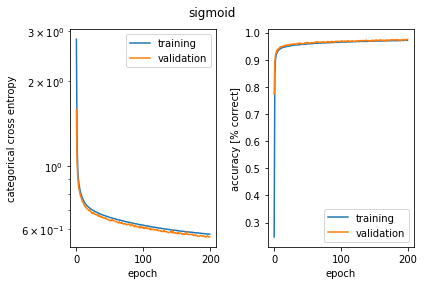

In [26]:
sigmoid = CNN(bn = False, activation = 'sigmoid', hidden_layer = True, filter_size = 64, learning_rate = 3e-4, epochs = 200, verbose = 0,
                          x_train = x_train_CNN, x_test = x_test_CNN, 
                          y_train = y_train, y_test = y_test)
fig = plot_history(sigmoid, 'sigmoid')

2. On Fashion-MNIST

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_5 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
activation_6 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
__________

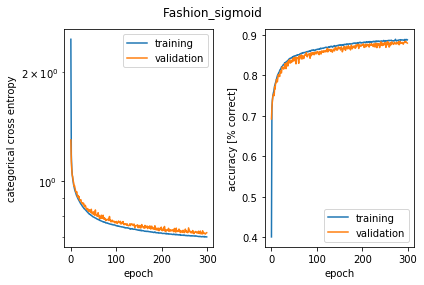

In [14]:
Fashion_sigmoid = CNN(bn = False, activation = 'sigmoid', hidden_layer = True, filter_size = 64, learning_rate = 3e-4, epochs = 300, verbose = 0,
                          x_train = x_fashion_train_CNN, x_test = x_fashion_test_CNN, 
                          y_train = y_fashion_train, y_test = y_fashion_test)
fig = plot_history(Fashion_sigmoid, 'Fashion_sigmoid')

**Training with batch normalization**
1. On MNIST

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
activation_3 (Activation)    (None, 14, 14, 64)        0         
__________

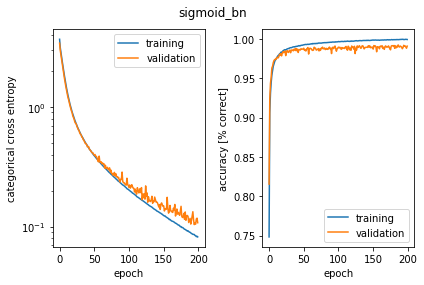

In [13]:
sigmoid_bn = CNN(bn = True, activation = 'sigmoid', hidden_layer = True, filter_size = 64, learning_rate = 1e-5, epochs = 200, verbose = 0,
                          x_train = x_train_CNN, x_test = x_test_CNN, 
                          y_train = y_train, y_test = y_test)
fig = plot_history(sigmoid_bn, 'sigmoid_bn')

> Comparing to the model without batch normalization, we can see that the accuracy on MNIST is not improved much. It is because MNIST is relatively easy. But as we can see below, on Fashion-MNIST, using batch normalization will bring an obvious improvement on accuracy.

2. On Fashion-MNIST

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_6 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
batch_normalization_6 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
activation_7 (Activation)    (None, 14, 14, 64)        0         
__________

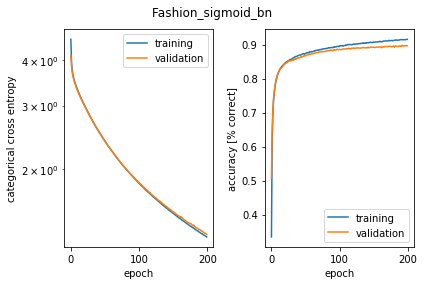

In [14]:
Fashion_sigmoid_bn = CNN(bn = True, activation = 'sigmoid', hidden_layer = True, filter_size = 64, learning_rate = 1e-6, epochs = 200, verbose = 0,
                          x_train = x_fashion_train_CNN, x_test = x_fashion_test_CNN, 
                          y_train = y_fashion_train, y_test = y_fashion_test)
fig = plot_history(Fashion_sigmoid_bn, 'Fashion_sigmoid_bn')

**Answer to question 1:**

Using Sigmoid as activation leads to lower accuracy.

**Answer to question 2:**

After implementing batch normalization, the performace is improved. 

---